# Assignment 
***

#### **1. Importing relevant packages** 
_Remember to install pydst (used to fetch data fro Statistics Denmark) if you have not already done that. Use: pip install git+https://github.com/elben10/pydst_

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydst
from pandas_datareader import wb
import ipywidgets as  widgets

#### **2. Importing data from online source**
We extract data from DST and start by getting an overview of the available data. 

In [113]:
# a. extrating data
Dst = pydst.Dst(lang='da')

# b. getting list of top-level subjects
Dst.get_subjects()

,active,desc,hasSubjects,id
0,True,Befolkning og valg,True,02
1,True,Levevilkår,True,05
2,True,Uddannelse og viden,True,03
3,True,Kultur og kirke,True,18
4,True,"Arbejde, indkomst og formue",True,04
5,True,Priser og forbrug,True,06
6,True,Nationalregnskab og offentlige finanser,True,14
7,True,Penge og kapitalmarked,True,16
8,True,Udenrigsøkonomi,True,13
9,True,Erhvervslivet på tværs,True,07


We choose the category **Levevilkår** (living conditions)

In [114]:
Dst.get_tables(subjects=['05']).head()

,active,firstPeriod,id,latestPeriod,text,unit,updated,variables
0,True,2008K1,FOLK1A,2019K1,Folketal den 1. i kvartalet,antal,2019-02-11 08:00:00,"[område, køn, alder, civilstand, tid]"
1,True,2008K1,FOLK1B,2019K1,Folketal den 1. i kvartalet,antal,2019-02-11 08:00:00,"[område, køn, alder, statsborgerskab, tid]"
2,True,2008K1,FOLK1C,2019K1,Folketal den 1. i kvartalet,antal,2019-02-11 08:00:00,"[område, køn, alder, herkomst, oprindelsesland..."
3,True,2008K1,FOLK1D,2019K1,Folketal den 1. i kvartalet,antal,2019-02-11 08:00:00,"[område, køn, alder, statsborgerskab, tid]"
4,True,2008K1,FOLK1E,2019K1,Folketal den 1. i kvartalet,antal,2019-02-11 08:00:00,"[område, køn, alder, herkomst, tid]"


Within the category **Living conditions** we choose **straf11** which contains data on reported criminal offences by _region_ and _type_ on a yearly basis from 2007 to 2018. 

In [115]:
Dst.get_data(table_id = 'straf22')

,OMRÅDE,OVERTRÆD,ANMSIGT,TID,INDHOLD
0,Hele landet,Overtrædelsens art i alt,Anmeldt,2007,514317


From this dataset, we construct a dataframe containing all observations on the variables _Area_, _Type of offence_, _Reported/charged_ and _Time_

In [116]:
crime_api = Dst.get_data(table_id = 'straf22',
                         variables={'OMRÅDE':['*'], 
                                    'OVERTRÆD':['*'],
                                    'ANMSIGT':['*'],
                                    'TID':['*']})


In [11]:
crime_api.head(10)

,OMRÅDE,OVERTRÆD,ANMSIGT,TID,INDHOLD
0,Allerød,Alvorligere vold,Anmeldt,2010,5
1,Allerød,Alvorligere vold,Sigtelser,2007,3
2,Allerød,Alvorligere vold,Sigtelser,2008,6
3,Allerød,Alvorligere vold,Sigtelser,2009,10
4,Allerød,Alvorligere vold,Sigtelser,2010,4
5,Allerød,Uagtsomt manddrab/legemsbeskadigelse,Anmeldt,2009,1
6,Allerød,Uagtsomt manddrab/legemsbeskadigelse,Sigtelser,2009,1
7,Allerød,Forbrydelse mod liv og legeme,Anmeldt,2008,1
8,Allerød,Forbrydelse mod liv og legeme,Anmeldt,2009,2
9,Allerød,Forbrydelse mod liv og legeme,Anmeldt,2010,1


#### **3. Overall impression of reported criminal offences on the country level (2007-2018)**
Selecting data and creating "table"


In [117]:
# Selecting country level, criminal offences total, reported criminal offences and
# all time periods
crime_land = crime_api.loc[(crime_api['OMRÅDE'] == 'Hele landet') & 
              (crime_api['OVERTRÆD'] == 'Overtrædelsens art i alt') & 
              (crime_api['ANMSIGT'] == 'Anmeldt'),:]

# Sorting data from 2007 to 2018
crime_land_sort = crime_land.sort_values(by='TID',ascending=True)

# Showing the timeseries in table
crime_land_sort.head(len(crime_land_sort['TID'])).style.hide_index()

OMRÅDE,OVERTRÆD,ANMSIGT,TID,INDHOLD
Hele landet,Overtrædelsens art i alt,Anmeldt,2007,514317
Hele landet,Overtrædelsens art i alt,Anmeldt,2008,548169
Hele landet,Overtrædelsens art i alt,Anmeldt,2009,562406
Hele landet,Overtrædelsens art i alt,Anmeldt,2010,545767
Hele landet,Overtrædelsens art i alt,Anmeldt,2011,558061
Hele landet,Overtrædelsens art i alt,Anmeldt,2012,531967
Hele landet,Overtrædelsens art i alt,Anmeldt,2013,535859
Hele landet,Overtrædelsens art i alt,Anmeldt,2014,518963
Hele landet,Overtrædelsens art i alt,Anmeldt,2015,501881
Hele landet,Overtrædelsens art i alt,Anmeldt,2016,516576


Zooming in at the the development in reported criminal offences since 2007-2018 on the country level

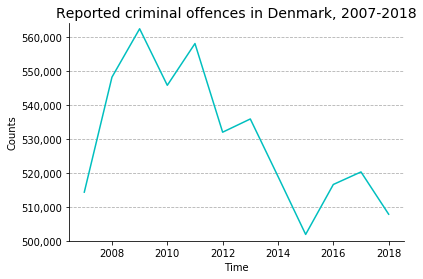

In [118]:
# a. actual plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
x = crime_land_sort['TID']
y = crime_land_sort['INDHOLD']

# b. labels
ax.set_xlabel('Time')
ax.set_ylabel('Counts')
ax.set_title('Reported criminal offences in Denmark, 2007-2018', fontsize=14)   

# c. including a grid, thousands separator on y-axis, removing plot frame lines
# and setting range of y-axis.
plt.grid(b=None, linestyle='--',which='major', axis='y')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.spines["top"].set_visible(False)       
ax.spines["right"].set_visible(False) 
plt.ylim(500000, 564000) 

# d. plotting cyan colored
ax.plot(x,y, 'c' )

#### **4. Investigating heterogeneity across Danish regions**
First step is to select observations on the regional level. 

In [119]:
# a. Constructing a boolean taking the value True if the OMRÅDE category contains the word
# Region and then selecting all these observations.
M = crime_api.OMRÅDE.str.contains('Region')
crime_M = crime_api[M]

# b. Selecting reported criminal offences in total from 2007-2018 
crime_reg = crime_M.loc[(crime_api['OVERTRÆD'] == 'Overtrædelsens art i alt') & 
              (crime_api['ANMSIGT'] == 'Anmeldt'),:]

# c. sorting in chronological order
crime_reg_sort = crime_reg.sort_values(by='TID',ascending=True)

crime_reg_sort.head(12)

,OMRÅDE,OVERTRÆD,ANMSIGT,TID,INDHOLD
961,Region Hovedstaden,Overtrædelsens art i alt,Anmeldt,2007,192915
1810,Region Syddanmark,Overtrædelsens art i alt,Anmeldt,2007,104273
3094,Region Sjælland,Overtrædelsens art i alt,Anmeldt,2007,64419
11322,Region Midtjylland,Overtrædelsens art i alt,Anmeldt,2007,101943
12175,Region Nordjylland,Overtrædelsens art i alt,Anmeldt,2007,44020
962,Region Hovedstaden,Overtrædelsens art i alt,Anmeldt,2008,201759
1811,Region Syddanmark,Overtrædelsens art i alt,Anmeldt,2008,113217
3095,Region Sjælland,Overtrædelsens art i alt,Anmeldt,2008,75670
12176,Region Nordjylland,Overtrædelsens art i alt,Anmeldt,2008,46149
11323,Region Midtjylland,Overtrædelsens art i alt,Anmeldt,2008,105901


#### **5. Summary statistics on sub-criminal offences**

In this section, we want to look at sub-criminal offences at the municipality level in 2018. Thus, we remove regions and observations on the country level. Furthermore, the variable _ANMSGT_ contains both reported and charged offences, hence, we split this variable into two separate variables in order to easily calculate the ratio between them later on. 

In [68]:
# a. deleting rows containing the words 'Region' and 'Hele landet'
for val in ['Region', 'Hele landet']: 
    I = crime_api.OMRÅDE.str.contains(val)
    crime_api = crime_api.loc[I == False] # keep everything else

Split the data into two dataframes in order to get separable variables for "anmeldt" and "sigtelser".
<br> **1. First** split: reported offences

In [71]:
# a. selection criteria
K = crime_api.OVERTRÆD.str.contains('i alt')

# b. creating dataset with only reported offences (ANMELDT)
crime_kom = crime_api[K].copy()
crime_kom_anm = crime_kom.loc[(crime_kom['TID'] == 2018) & 
              (crime_api['ANMSIGT'] == 'Anmeldt'),:]
crime_kom_anm.rename(columns = {'INDHOLD':'ANMELDT'}, inplace=True)
del crime_kom_anm['ANMSIGT']

# c. evaluating the result
crime_kom_anm.head().style.hide_index()


OMRÅDE,OVERTRÆD,TID,ANMELDT
Slagelse,Voldsforbrydelser i alt,2018,564
Slagelse,Ejendomsforbrydelser i alt,2018,3939
Syddjurs,Andre straffelovsforbrydelser i alt,2018,46
Syddjurs,Særlove i alt,2018,618
Syddjurs,Overtrædelsens art i alt,2018,2203


**2. Second** split: charged offences

In [73]:
# a. using same selection criteria to create dataset with charges only (SIGTELSER)
crime_kom = crime_api[K]
crime_kom_sigt = crime_kom.loc[(crime_kom['TID'] == 2018) & 
              (crime_api['ANMSIGT'] == 'Sigtelser'),:].copy()
crime_kom_sigt.rename(columns = {'INDHOLD':'SIGTELSER'}, inplace=True)
del crime_kom_sigt['ANMSIGT']

# b. evaluating the result
crime_kom_sigt.head().style.hide_index()


OMRÅDE,OVERTRÆD,TID,SIGTELSER
Slagelse,Voldsforbrydelser i alt,2018,380
Slagelse,Ejendomsforbrydelser i alt,2018,823
Syddjurs,Andre straffelovsforbrydelser i alt,2018,35
Syddjurs,Særlove i alt,2018,285
Syddjurs,Overtrædelsens art i alt,2018,644


Printing number of rows in new variables

In [158]:
print(f'Observations in crime_kom_sigt = {len(crime_kom_sigt)}')
print(f'Observations in crime_kom_anm  = {len(crime_kom_anm)}')

Observations in crime_kom_sigt = 690
Observations in crime_kom_anm  = 694


The difference between the two measures indicates that there are four areas where there are reported offences, however, no charges. This could reflect the fact that reported and charged offences of the same crime are not necessarily registered in the same year.

**3. Merge** two separate datasets back together into one dataframe.

In [103]:
# a. merging
crime_kom_merged = pd.merge(crime_kom_anm, crime_kom_sigt, 
                            on=['OMRÅDE', 'OVERTRÆD', 'TID'], how='outer')
# b. replace NaNs with zeroes
crime_kom_merged['SIGTELSER'] = crime_kom_merged['SIGTELSER'].fillna(0)

# c. for some reason, 'SIGTELSER' turned into float. change them back to integers
crime_kom_merged['SIGTELSER'] = crime_kom_merged['SIGTELSER'].astype(int)
crime_kom_merged.head(10).style.hide_index()

OMRÅDE,OVERTRÆD,TID,ANMELDT,SIGTELSER
Slagelse,Voldsforbrydelser i alt,2018,564,380
Slagelse,Ejendomsforbrydelser i alt,2018,3939,823
Syddjurs,Andre straffelovsforbrydelser i alt,2018,46,35
Syddjurs,Særlove i alt,2018,618,285
Syddjurs,Overtrædelsens art i alt,2018,2203,644
Norddjurs,Straffelov i alt,2018,1534,510
Norddjurs,Seksualforbrydelser i alt,2018,36,27
Norddjurs,Voldsforbrydelser i alt,2018,255,201
Norddjurs,Ejendomsforbrydelser i alt,2018,1196,244
Norddjurs,Andre straffelovsforbrydelser i alt,2018,47,38


**4. Creating** a new variable called 'ANDEL SIGTEDE', which is the share of reported crimes that actually ends with a criminal charge. The following analysis hinges on one important assumption: 1. There is no guarantee that reported and charged offences of the same crime are registered in the same year. Hence, the ratio of charges relative to reported offences does not necessarily capture the real ratio between charges and reported offences. However, we will assume that reported and charged offences of the same crime are attributed to the same year. 

In [77]:
# a. calculating the ratio
crime_kom_merged['ANDEL SIGTEDE'] = crime_kom_merged['SIGTELSER'] / crime_kom_merged['ANMELDT'] * 100

# b. rounding the number to two decimals
crime_kom_merged['ANDEL SIGTEDE'] = round(crime_kom_merged['ANDEL SIGTEDE'], 2)

# c. showing a sample of 10 observations
crime_kom_merged.sample(10).style.hide_index()

OMRÅDE,OVERTRÆD,TID,ANMELDT,SIGTELSER,ANDEL SIGTEDE
Guldborgsund,Seksualforbrydelser i alt,2018,89,63,70.79
Guldborgsund,Særlove i alt,2018,1299,703,54.12
Frederikssund,Voldsforbrydelser i alt,2018,222,118,53.15
Fanø,Overtrædelsens art i alt,2018,233,72,30.9
Glostrup,Andre straffelovsforbrydelser i alt,2018,66,42,63.64
Lejre,Seksualforbrydelser i alt,2018,11,5,45.45
Allerød,Voldsforbrydelser i alt,2018,77,30,38.96
Norddjurs,Seksualforbrydelser i alt,2018,36,27,75
Ballerup,Voldsforbrydelser i alt,2018,218,145,66.51
Ringkøbing-Skjern,Særlove i alt,2018,642,387,60.28


**Extreme 1:** The 12 municipalities with the highest share of charged offences relative to reported offences in 2018. 

In [88]:
# a. sort in descending order
crime_kom_merged = crime_kom_merged.sort_values(by='ANDEL SIGTEDE',ascending=False)

# b. table of 12 municipalities with highest ratio
crime_kom_merged.head(12).style.hide_index()


OMRÅDE,OVERTRÆD,TID,ANMELDT,SIGTELSER,ANDEL SIGTEDE
Samsø,Andre straffelovsforbrydelser i alt,2018,1,1,100
Ishøj,Seksualforbrydelser i alt,2018,270,262,97.04
Viborg,Andre straffelovsforbrydelser i alt,2018,371,354,95.42
Faxe,Andre straffelovsforbrydelser i alt,2018,19,18,94.74
Hjørring,Seksualforbrydelser i alt,2018,182,167,91.76
Odder,Andre straffelovsforbrydelser i alt,2018,11,10,90.91
Hørsholm,Seksualforbrydelser i alt,2018,31,28,90.32
Fredensborg,Seksualforbrydelser i alt,2018,72,65,90.28
Syddjurs,Seksualforbrydelser i alt,2018,53,47,88.68
Ikast-Brande,Seksualforbrydelser i alt,2018,26,23,88.46


**Extreme 2:** The 12 municipalities with the lowest share of charged offences relative to reported offences in 2018. 

In [89]:
# a. sort in ascending order
crime_kom_merged = crime_kom_merged.sort_values(by='ANDEL SIGTEDE',ascending=True)

# b. table of 12 municipalities
crime_kom_merged.head(12).style.hide_index()

OMRÅDE,OVERTRÆD,TID,ANMELDT,SIGTELSER,ANDEL SIGTEDE
Christiansø,Overtrædelsens art i alt,2018,1,0,0
Samsø,Seksualforbrydelser i alt,2018,2,0,0
Christiansø,Særlove i alt,2018,1,0,0
Læsø,Voldsforbrydelser i alt,2018,1,0,0
Ikast-Brande,Særlove i alt,2018,14477,412,2.85
Ikast-Brande,Overtrædelsens art i alt,2018,16093,839,5.21
Gentofte,Ejendomsforbrydelser i alt,2018,4827,326,6.75
Egedal,Ejendomsforbrydelser i alt,2018,1344,93,6.92
Hørsholm,Særlove i alt,2018,1054,77,7.31
Vallensbæk,Ejendomsforbrydelser i alt,2018,655,53,8.09


Calculating the mean of the share of charged offences relative to reported offences by type of offence

In [163]:
crime_kom_merged.groupby('OVERTRÆD').mean().sort_values(by='ANDEL SIGTEDE',ascending=False)

,TID,ANMELDT,SIGTELSER,ANDEL SIGTEDE
OVERTRÆD,,,,
Seksualforbrydelser i alt,2018.0,74.040816,51.642857,67.028163
Andre straffelovsforbrydelser i alt,2018.0,104.040404,71.383838,66.182525
Voldsforbrydelser i alt,2018.0,281.373737,170.444444,61.941111
Særlove i alt,2018.0,1442.820000,706.280000,52.378800
Overtrædelsens art i alt,2018.0,5078.240000,1581.580000,31.441100
Straffelov i alt,2018.0,3672.141414,884.141414,24.633737
Ejendomsforbrydelser i alt,2018.0,3213.434343,591.191919,17.905354


#### **5. Mapping the ratio of charges to reported offences on the municipality level in a socalled choropleth** 
In the following section we construct a map over x. To run the map can be cumbersome, since you need to read a shape file, which requires the installation of GDAL and other packages. If you have windows, the road to installation is long and tiredsome. However, we have constructed a recipe for the installation:

In [104]:
# selecting the data to plot in the chloropeth 
crime_mun = crime_kom_merged.copy()
crime_mun1 = crime_mun.loc[(crime_mun['OVERTRÆD'] == 'Overtrædelsens art i alt'),:]

crime_mun1.head()

,OMRÅDE,OVERTRÆD,TID,ANMELDT,SIGTELSER
4,Syddjurs,Overtrædelsens art i alt,2018,2203,644
11,Norddjurs,Overtrædelsens art i alt,2018,2245,935
18,Favrskov,Overtrædelsens art i alt,2018,2039,582
27,Odsherred,Overtrædelsens art i alt,2018,2534,620
34,Roskilde,Overtrædelsens art i alt,2018,7825,2983


Install **geopandas** (if windows follow links in readme) if not already installed

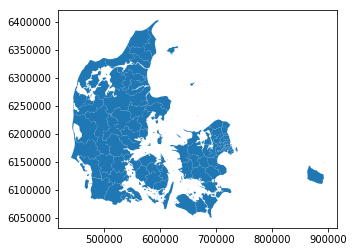

In [98]:
# a. import geopandas
import geopandas as gpd

# b. read shape file
file = 'KOMMUNE.shp'
map_df = gpd.read_file(file)

# c. plot map
map_df.plot()

**Merge** dataset with ratio onto geological data 

In [100]:
# a. merge through municipality
merged = map_df.set_index('KOMNAVN').join(crime_mun1.set_index('OMRÅDE'))

# b. look at data
merged.head()

,FEAT_ID,FEAT_KODE,FEAT_TYPE,FEAT_STTXT,GEOM_STTXT,DAGI_ID,AREAL,REGIONKODE,REGIONNAVN,GYLDIG_FRA,...,TIMEOF_CRE,TIMEOF_PUB,TIMEOF_REV,TIMEOF_EXP,geometry,OVERTRÆD,TID,ANMELDT,SIGTELSER,ANDEL SIGTEDE
Aabenraa,250591,6310,Kommune,vedtaget,endelig,389169,94061.2,1083,Region Syddanmark,2018-01-22,...,2018-01-22,2018-01-22,None,2019-03-23,"POLYGON Z ((532245.9400000001 6079144.94 -999,...",Overtrædelsens art i alt,2018,5285,2016,38.15
Aabenraa,250589,6310,Kommune,vedtaget,endelig,389169,94061.2,1083,Region Syddanmark,2018-01-22,...,2018-01-22,2018-01-22,None,2019-03-23,"POLYGON Z ((532579.09 6078987.87 -999, 532579....",Overtrædelsens art i alt,2018,5285,2016,38.15
Aabenraa,250593,6310,Kommune,vedtaget,endelig,389169,94061.2,1083,Region Syddanmark,2018-01-22,...,2018-01-22,2018-01-22,None,2019-03-23,"POLYGON Z ((529349.23 6107743.85 -999, 529353....",Overtrædelsens art i alt,2018,5285,2016,38.15
Aabenraa,250587,6310,Kommune,vedtaget,endelig,389169,94061.2,1083,Region Syddanmark,2018-01-22,...,2018-01-22,2018-01-22,None,2019-03-23,"POLYGON Z ((536464.0600000001 6107571.33 -999,...",Overtrædelsens art i alt,2018,5285,2016,38.15
Aabenraa,250585,6310,Kommune,vedtaget,endelig,389169,94061.2,1083,Region Syddanmark,2018-01-22,...,2018-01-22,2018-01-22,None,2019-03-23,"POLYGON Z ((529191.3 6107597.05 -999, 529192.6...",Overtrædelsens art i alt,2018,5285,2016,38.15


Create the map

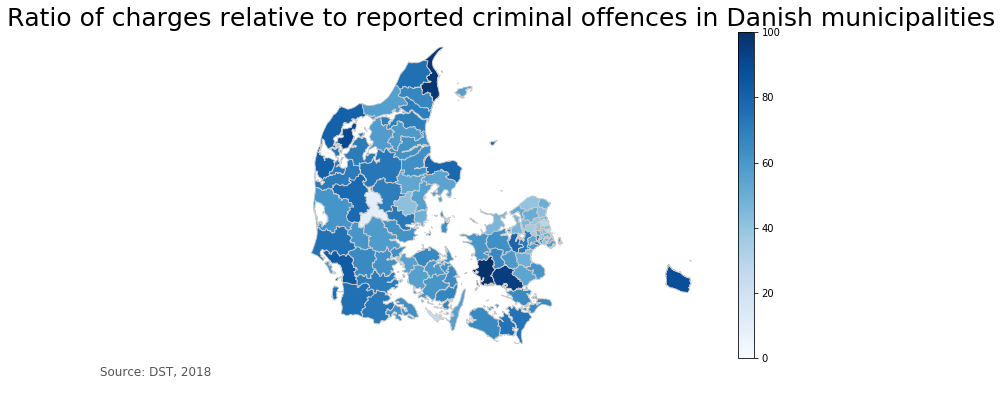

In [102]:
# specify the variable (column in merged dataframe) to visualize on the map
variable = 'ANDEL SIGTEDE'

# range of variable
vmin, vmax = 0, 100

# create figure and axes 
fig, ax = plt.subplots(1,figsize=(10,6))

# plot the map
merged.plot(column=variable,cmap='Blues',linewidth=0.8,ax=ax,edgecolor='0.8')

##### Costumising the map #####
# remove the axis
ax.axis('off')

# Title
ax.set_title('Ratio of charges relative to reported criminal offences in Danish municipalities', fontdict={'fontsize': '25', 'fontweight' : '3'})

# Annotation for the data source
ax.annotate('Source: DST, 2018',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
            
# Colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# The colorbar to the figure
cbar = fig.colorbar(sm)